In [136]:
from frgpascal.analysis.processing import load_all, compress_jv, get_worklist_times
from frgpascal.analysis.brightfield import load_image
from frgtrainview.analysis.crop import crop_pl
from scipy import stats
from natsort import natsorted
from natsort import index_natsorted
import copy
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colorbar
import seaborn as sns
import warnings
from tqdm import tqdm
from matplotlib import style
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
import os
import json
import pickle as pkl
import time
from PIL import Image

# plotting settings
# %config InlineBackend.figure_format = 'retina'
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams["axes.linewidth"] = 1.75  # set the value globally

import os
import glob
import shutil

import keras
import tensorflow as tf

from skimage.util import random_noise
from tifffile import imread
from skimage.transform import rotate


In [2]:
source = '/Users/deniz/Documents/GitHub/PASCAL_TrainView/analysis_experiments/rotate_CNN/raw_data'
destination = f'/Users/deniz/Documents/GitHub/PASCAL_TrainView/analysis_experiments/rotate_CNN/PL_images'

In [3]:
# move just the PL images and add batch id to the file name
for folder, subfolders, files in os.walk(source):
    if folder != source:
        for f in files:
            if f.endswith("5000ms.tif"):
                # print("File Name: ", f)
                # print(f"Path: ", os.path.join(folder, f))
                file_name_temp = f
                file_path_temp = os.path.join(folder, f)
                file_path_dir = os.path.dirname(file_path_temp)
                batch_name = file_path_dir.split('_')[5].split('-')[0]
                os.rename(f'{file_path_temp}', f'{file_path_dir}/{batch_name}_{file_name_temp}')
                renamed_path_temp = os.path.join(file_path_dir, f'{batch_name}_{file_name_temp}')
                shutil.move(renamed_path_temp, destination)

In [4]:
crop_desitnation = '/Users/deniz/Documents/GitHub/PASCAL_TrainView/analysis_experiments/rotate_CNN/cropped_PL_images'
source = '/Users/deniz/Documents/GitHub/PASCAL_TrainView/analysis_experiments/rotate_CNN/raw_PL_images'

In [5]:
# crop the PL images
fids = glob.glob(f'{source}/*.tif')

In [43]:
for fid in fids:
    base_name = os.path.basename(fid)
    temp_image = load_image(fid)
    crop_image = crop_pl(np.uint8(temp_image * 255), output_shape=(256,256))[0]
    Image.fromarray(crop_image[:,:,1]).save(f'{crop_desitnation}/{base_name}')

In [102]:
# manual bins
fid_manual_bin_up = '/Users/deniz/Documents/GitHub/PASCAL_TrainView/analysis_experiments/rotate_CNN/manually_binned/up'
fid_manual_bin_down = '/Users/deniz/Documents/GitHub/PASCAL_TrainView/analysis_experiments/rotate_CNN/manually_binned/down'
fid_manual_bin_left = '/Users/deniz/Documents/GitHub/PASCAL_TrainView/analysis_experiments/rotate_CNN/manually_binned/left'
fid_manual_bin_right = '/Users/deniz/Documents/GitHub/PASCAL_TrainView/analysis_experiments/rotate_CNN/manually_binned/right'

In [104]:
up_fids = glob.glob(f'{fid_manual_bin_up}/*.tif')

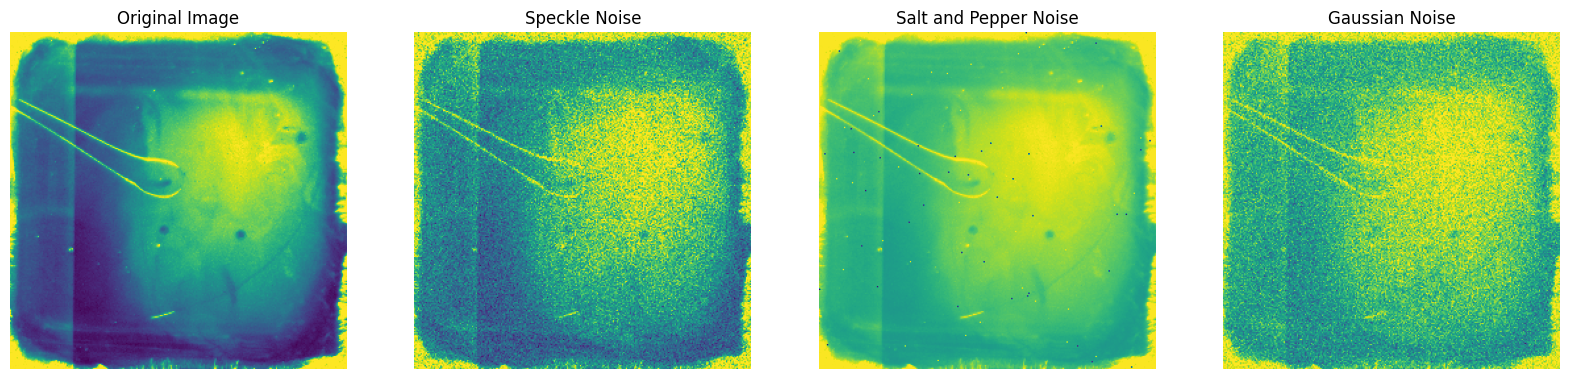

In [120]:
temp_image = rotate(imread(up_fids[0])[:,:,1], -270)
speckle_noise_image = random_noise(temp_image, mode='speckle', seed=None, clip=True)
snp_noise_image = random_noise(temp_image, mode='s&p', seed=None, clip=True, amount=0.001)
gauss_noise_image = random_noise(temp_image, mode='gaussian', seed=None, clip=True)

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(temp_image)
ax[1].imshow(speckle_noise_image)
ax[2].imshow(snp_noise_image)
ax[3].imshow(gauss_noise_image)
ax[0].set_title('Original Image')
ax[1].set_title('Speckle Noise')
ax[2].set_title('Salt and Pepper Noise')
ax[3].set_title('Gaussian Noise')

for ax in ax:
    ax_axis = ax.axis('off')
plt.show()

In [170]:
source = '/Users/deniz/Documents/GitHub/PASCAL_TrainView/analysis_experiments/rotate_CNN/manually_binned'
destination = '/Users/deniz/Documents/GitHub/PASCAL_TrainView/analysis_experiments/rotate_CNN/augmented_manually_binned'

In [171]:
# converting all images to grayscale off of green channel and distributing image into each direction
for folder, subfolders, files in os.walk(source):
    if folder != source:
        for f in files:
            if f.endswith("5000ms.tif"):
                # print("File Name: ", f)
                # print(f"Path: ", os.path.join(folder, f))
                file_name_temp = f
                file_path_temp = os.path.join(folder, f)
                file_path_dir = os.path.dirname(file_path_temp)
                direction = file_path_dir.split('/')[-1]
                
                temp_imag_array_green = imread(file_path_temp)[:,:,1] # green channel
                
                rotate_angles = [-90, -180, -270]
                
                # distribute one image to all 4 directions
                if direction == 'up':
                    image_up = temp_imag_array_green
                    image_right = rotate(temp_imag_array_green, rotate_angles[0])
                    image_down = rotate(temp_imag_array_green, rotate_angles[1])
                    image_left = rotate(temp_imag_array_green, rotate_angles[2])
                    
                    Image.fromarray(np.uint8(image_up * 255)).save(f'{destination}/up/{file_name_temp}')
                    Image.fromarray(np.uint8(image_right * 255)).save(f'{destination}/right/{file_name_temp}')
                    Image.fromarray(np.uint8(image_down * 255)).save(f'{destination}/down/{file_name_temp}')
                    Image.fromarray(np.uint8(image_left * 255)).save(f'{destination}/left/{file_name_temp}')
                    
                if direction == 'right':
                    image_right = temp_imag_array_green
                    image_down = rotate(temp_imag_array_green, rotate_angles[0])
                    image_left = rotate(temp_imag_array_green, rotate_angles[1])
                    image_up = rotate(temp_imag_array_green, rotate_angles[2])
                    
                    Image.fromarray(np.uint8(image_up * 255)).save(f'{destination}/up/{file_name_temp}')
                    Image.fromarray(np.uint8(image_right * 255)).save(f'{destination}/right/{file_name_temp}')
                    Image.fromarray(np.uint8(image_down * 255)).save(f'{destination}/down/{file_name_temp}')
                    Image.fromarray(np.uint8(image_left * 255)).save(f'{destination}/left/{file_name_temp}')
                    
                if direction == 'down':
                    image_down = temp_imag_array_green
                    image_left = rotate(temp_imag_array_green, rotate_angles[0])
                    image_up = rotate(temp_imag_array_green, rotate_angles[1])
                    image_right = rotate(temp_imag_array_green, rotate_angles[2])

                    Image.fromarray(np.uint8(image_up * 255)).save(f'{destination}/up/{file_name_temp}')
                    Image.fromarray(np.uint8(image_right * 255)).save(f'{destination}/right/{file_name_temp}')
                    Image.fromarray(np.uint8(image_down * 255)).save(f'{destination}/down/{file_name_temp}')
                    Image.fromarray(np.uint8(image_left * 255)).save(f'{destination}/left/{file_name_temp}')
                
                if direction == 'left':
                    iamge_left = temp_imag_array_green
                    image_up = rotate(temp_imag_array_green, rotate_angles[0])
                    image_right = rotate(temp_imag_array_green, rotate_angles[1])
                    image_down = rotate(temp_imag_array_green, rotate_angles[2])

                    Image.fromarray(np.uint8(image_up * 255)).save(f'{destination}/up/{file_name_temp}')
                    Image.fromarray(np.uint8(image_right * 255)).save(f'{destination}/right/{file_name_temp}')
                    Image.fromarray(np.uint8(image_down * 255)).save(f'{destination}/down/{file_name_temp}')
                    Image.fromarray(np.uint8(image_left * 255)).save(f'{destination}/left/{file_name_temp}')
                    
                            
                



In [172]:
source = '/Users/deniz/Documents/GitHub/PASCAL_TrainView/analysis_experiments/rotate_CNN/augmented_manually_binned'
destination = '/Users/deniz/Documents/GitHub/PASCAL_TrainView/analysis_experiments/rotate_CNN/augmented_manually_binned'

In [173]:
# adding noise 1000 times per image per noise type
# 
for folder, subfolders, files in os.walk(source):
    if folder != source:
        for f in files:
            if f.endswith("5000ms.tif"):
                # print("File Name: ", f)
                # print(f"Path: ", os.path.join(folder, f))
                file_name_temp = f
                file_path_temp = os.path.join(folder, f)
                file_path_dir = os.path.dirname(file_path_temp)
                direction = file_path_dir.split('/')[-1]
                # print(direction)
                temp_image_array = imread(file_path_temp)

                noise_list = ['speckle', 's&p', 'gaussian']
                
                for n in range(0, 5, 1):
                    for noise_type in noise_list:
                        if noise_type == 'speckle':
                            speckle_noise_image = random_noise(temp_image_array, mode='speckle', seed=None, clip=True)
                            Image.fromarray(np.uint8(speckle_noise_image * 255)).save(f'{destination}/{direction}/speckle_{n}_{file_name_temp}')
                        if noise_type == 's&p':
                            snp_noise_image = random_noise(temp_image_array, mode='s&p', seed=None, clip=True, amount=0.001)
                            Image.fromarray(np.uint8(snp_noise_image * 255)).save(f'{destination}/{direction}/snp_{n}_{file_name_temp}')
                        if noise_type == 'gaussian':
                            gaus_noise_image = random_noise(temp_image_array, mode='gaussian', seed=None, clip=True)
                            Image.fromarray(np.uint8(gaus_noise_image * 255)).save(f'{destination}/{direction}/gauss_{n}_{file_name_temp}')